# Hands-on-ml 
# MNIST (Classification Example)

## 1. Data load

In [1]:
import pandas as pd, numpy as np
import seaborn as sns

In [2]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata

from scipy.io import loadmat
mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
response = urllib.request.urlopen(mnist_alternative_url)
with open(mnist_path, "wb") as f:
    content = response.read()
    f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success!")

Success!


In [3]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

There are 70,000 images and each image has 784 features.(28*28)

##### Draw just one example to explore and predict

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)

<function matplotlib.pyplot.show>

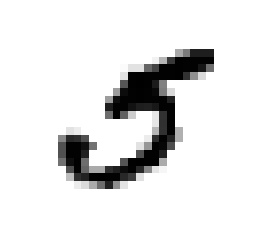

In [7]:
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off") # delete line
plt.show

In [8]:
y[36000]

5.0

This dataset is already splitted, trainset and test set.

I have to shuffled.

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

shuffle_index = np.random.permutation(60000)

In [10]:
shuffle_index

array([20564, 33221, 38398, ..., 44979, 58286, 54825])

In [11]:
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 2.  Binary Classifier

### For only 5 (5 or not)

##### Binary classification is more simple example of classification

In [12]:
y_train_5 = (y_train == 5)
y_test_5  = (y_test == 5)

Using Stochastic Gradient Descent

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

## 3. Performance measure

### 3.1 Crossvalidation

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
stratK = StratifiedKFold(n_splits=10, random_state=42)

sgd_clf_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=stratK, scoring='accuracy')

In [16]:
sgd_clf_score

array([0.96433928, 0.89016667, 0.96383333, 0.9605    , 0.9615    ,
       0.96533333, 0.96816667, 0.9685    , 0.96133333, 0.95865978])

The score of all 10fold cross validation is quite high. 

#####  But It shows Measuring Performance by 'accuracy' is not good way. 
We use confusion matrix for more reasonable measure

### 3.2 Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
y_train_pred

array([False,  True, False, ..., False, False, False])

###### Using cross_val_predict which give us not a score but actual prediction, 
We can compare answer and prediction by confusion matrix

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54311,   268],
       [ 2121,  3300]], dtype=int64)

There are several term to measure performance.(Recall, Sensitivity, F1-score, Precision)

That which performance index is important depends on what problem is to solve by machine learning.

I'm not going to check and explain all performance index in this notebook.

### 3.3 Precision and Recall

In [20]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.9248878923766816

In [21]:
recall_score(y_train_5, y_train_pred)

0.6087437742114001

We can use 'F1 score' harmonic mean of precision and recall

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7342307264434308

### 3.4 Tradeoff of Precision/Recall

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([107814.87130677])

#### Threshold = 0

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

#### Threshold = 200000

In [25]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

##### Then, how to find proper threshold?

##### Use Precision Recall Curve

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

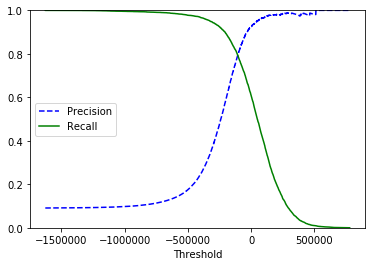

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc='center left')
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### 3.5 ROC Curve

It uses **Sensitivity** 

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

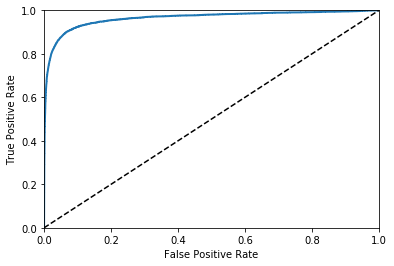

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

By measuring AUC of ROC curve we can choose better model.

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9642332331108591

## 4. Multi Class Classifier

Multi Class Classifier can classify more than 2 class.

Except Random forest or Naive Bayes, SVM or other linear model can be used for binary classification.

But, thess algorithm can also be used in multi-class classfier using multiple binary classification.

**One_vs_All**

- It makes classifier according to number of class.
- To classify, It classifies data with the highest score among decision score

**One_vs_One**

- It makes multiple binary classifier to classify each combination of class ((A,B), (A,C), (A,D), (B,C), ..., (C,D))
- To classify, It makes datapoint get through all classifier.
- One advantage of this is, it only need sample for classify two classes. (SVM is preferable to use this, but normally, OvA is used)



sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

SGD automatically use OvA method.

In [32]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([107814.87130677])

In [33]:
np.argmax(some_digit_scores)

0

In [34]:
sgd_clf.classes_

array([False,  True])

If you want another method by force,

Use **OneVsOneClassfier** or **OneVsRestClassifier**.

In [35]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([3.])

## 5. MultiLabel Classification

There is some problem to classify multipleclass for one dataset.

For example, If the picture has to be classified by that whether there are Bob, John and Sally or not. [0, 1, 1]

This kinds of classification is called multilabel classification.

In [36]:
'''
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
'''

'\nfrom sklearn.neighbors import KNeighborsClassifier\n\ny_train_large = (y_train >= 7)\ny_train_odd = (y_train % 2 == 1)\ny_multilabel = np.c_[y_train_large, y_train_odd]\n\nknn_clf = KNeighborsClassifier()\nknn_clf.fit(X_train, y_multilabel)\n'

Usually, F1 score is used to measure multilabel classfication.

In [37]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
#f1_score(y_multilabel, y_train_knn_pred, average='macro')

If you want to give some weight on specific class, then set average='weighted'